In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from transformers import AutoTokenizer
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/dev2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
file = "amazon_reviews_us_Camera_v1_00.tsv"

#reading tsv file
csv_table = pd.read_table(file, sep='\t', on_bad_lines='skip')

#converting tsv file into csv
csv_table.to_csv('camera_reviews.csv', index=False)

df = pd.read_csv('camera_reviews.csv')

df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,2975964,R1NBG94582SJE2,B00I01JQJM,860486164,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,Camera,5,0,0,N,Y,Five Stars,ok,2015-08-31
1,US,23526356,R273DCA6Y0H9V7,B00TCO0ZAA,292641483,Professional 58mm Center Pinch Lens Cap for CA...,Camera,5,0,0,N,Y,Love it!!!,"Perfect, even sturdier than the original!",2015-08-31
2,US,52764145,RQVOXO7WUOFK6,B00B7733E0,75825744,Spy Tec Z12 Motion Activated Intelligent Secur...,Camera,2,1,1,N,Y,Another Motion Detect Fail,"If the words, &#34;Cheap Chinese Junk&#34; com...",2015-08-31
3,US,47348933,R1KWKSF21PO6HO,B006ZN4U34,789352955,"Celestron UpClose G2 10x25 Monocular, Black (7...",Camera,5,0,0,N,Y,Exactly what I wanted and expected.,Exactly what I wanted and expected. Perfect fo...,2015-08-31
4,US,33680700,R38H3UO1J190GI,B00HUEBGMU,19067902,Vidpro XM-L Wired Lavalier microphone - 20' Au...,Camera,5,1,1,N,Y,Good mic at a Good Price...Not Canon Though.,I will look past the fact that they tricked me...,2015-08-31


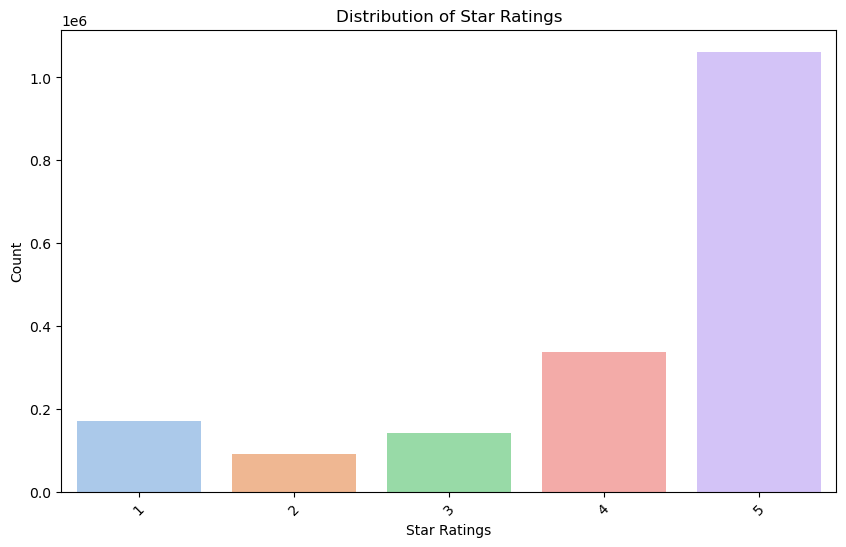

In [5]:
def column_chart(attribute, label):
  plt.figure(figsize=(10, 6))
  sns.countplot(x=attribute, data=df, palette='pastel')
  plt.xlabel(label)
  plt.ylabel('Count')
  plt.title(f'Distribution of {label}')
  plt.xticks(rotation=45)
  plt.show()

column_chart('star_rating', 'Star Ratings')

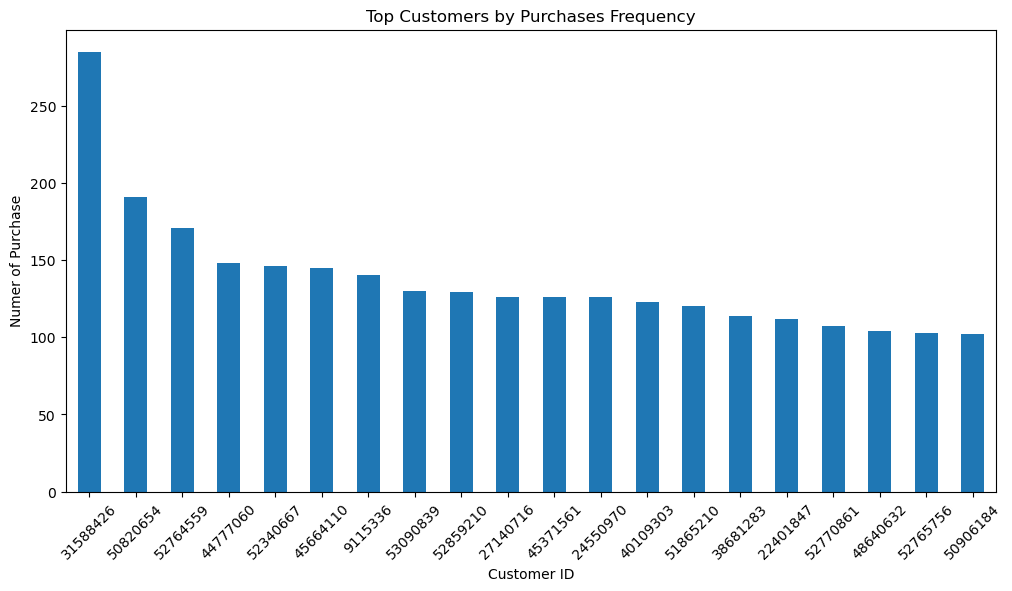

In [6]:
def plot_customer_purchase_freq(attribute, num_customer):
    customer_counts = df[attribute].value_counts().nlargest(num_customer)
    
    # create the bar chart
    plt.figure(figsize=(12, 6))
    customer_counts.plot(kind='bar')
    plt.xlabel('Customer ID')
    plt.ylabel('Numer of Purchase')
    plt.title(f'Top Customers by Purchases Frequency'.format(num_customer))
    plt.xticks(rotation=45)
    plt.show()

plot_customer_purchase_freq('customer_id', 20)

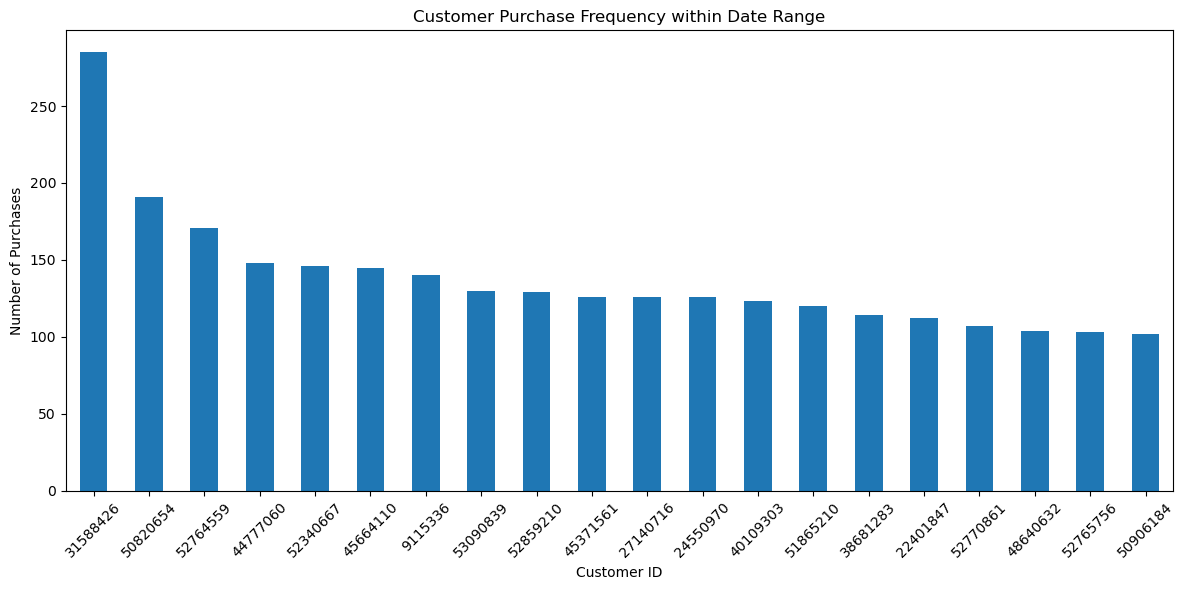

In [11]:

def plot_customer_purchase_frequency_date_range(data, num_customer, start_date=None, end_date=None):
    """
    Plots a bar chart of customer purchase frequency within a specified date range.

    Args:
        data (pd.DataFrame): DataFrame containing 'customer_id' and 'review_date' columns.
        start_date (str, optional): Start date for the analysis (YYYY-MM-DD). Defaults to None (no start date limit).
        end_date (str, optional): End date for the analysis (YYYY-MM-DD). Defaults to None (no end date limit).
    """

    # Input validation
    if 'customer_id' not in data.columns or 'review_date' not in data.columns:
        print("Error: 'customer_id' or 'review_date' column not found.")
        return

    try:
        data['review_date'] = pd.to_datetime(data['review_date'])
    except ValueError:
        print("Error: 'review_date' column must be in YYYY-MM-DD format.")
        return

    # Apply date range filter
    if start_date:
        try:
            start_date = pd.to_datetime(start_date)
            data = data[data['review_date'] >= start_date]
        except ValueError:
            print("Error: Invalid start_date format. Use YYYY-MM-DD.")
            return
    if end_date:
        try:
            end_date = pd.to_datetime(end_date)
            data = data[data['review_date'] <= end_date]
        except ValueError:
            print("Error: Invalid end_date format. Use YYYY-MM-DD.")
            return

    # Count purchases per customer
    customer_counts = data['customer_id'].value_counts().nlargest(num_customer)

    #Plot the bar chart
    plt.figure(figsize=(12, 6))
    customer_counts.plot(kind='bar')
    plt.title('Customer Purchase Frequency within Date Range')
    plt.xlabel('Customer ID')
    plt.ylabel('Number of Purchases')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Call the function (no date range specified)
#plot_customer_purchase_frequency_date_range(df, 20)

# Call the function with a start date
#plot_customer_purchase_frequency_date_range(df, 20, start_date='1995-08-25')

# Call the function with a start and end date
plot_customer_purchase_frequency_date_range(df, 20,start_date='2000-01-01', end_date='2015-08-31')



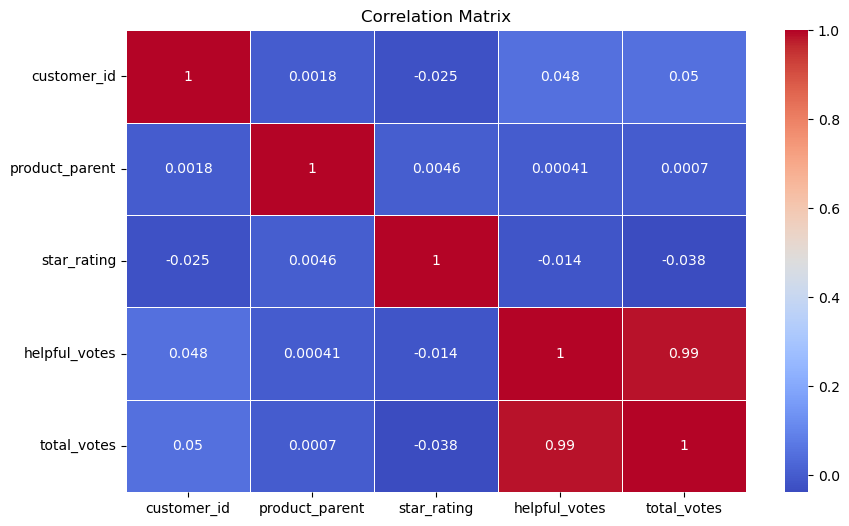

In [15]:
# Function to display correlation matrix using Pandas corr function
def correlation_matrix():
  corr_matrix = df.corr(numeric_only=True)
  plt.figure(figsize=(10, 6))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
  plt.title('Correlation Matrix')
  plt.show()

correlation_matrix()

/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/808145086.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=attribute, data=df, palette='pastel')


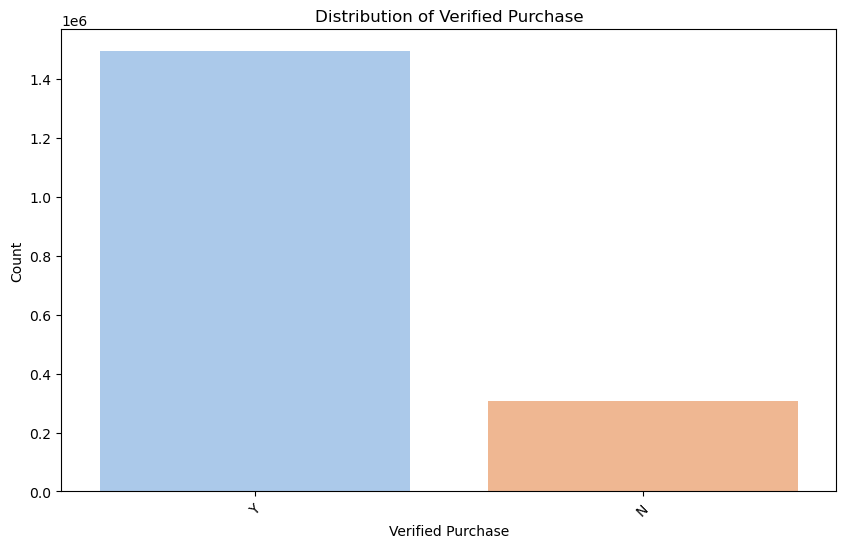

In [16]:
column_chart('verified_purchase', 'Verified Purchase')

In [17]:
df['review_combined'] = df.review_body + ' ' + df.review_headline + ' ' + df.product_title

print(df.review_combined.isna().sum())
df.dropna(subset=['review_combined'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.review_combined.isna().sum())

110
0


In [18]:
reviews_data = df[['star_rating', 'review_combined', 'review_date']]
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800735 entries, 0 to 1800734
Data columns (total 3 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   star_rating      int64 
 1   review_combined  object
 2   review_date      object
dtypes: int64(1), object(2)
memory usage: 41.2+ MB


In [19]:
review_http = reviews_data[reviews_data.review_combined.str.contains(r'^(?=.*/>)(?=.*http)')]
review_http

,star_rating,review_combined,review_date
181,1,"We purchased a Defender brand DVR on March 3, ...",2015-08-31
604,1,"We purchased a Defender brand DVR on March 3, ...",2015-08-31
637,1,"We purchased a Defender brand DVR on March 3, ...",2015-08-31
681,1,"We purchased a Defender brand DVR on March 3, ...",2015-08-31
989,5,The Phantom 3 is awesome! Check this out:<br ...,2015-08-31
...,...,...,...
1769779,5,Addendum 3/30: To correct the guy correcting ...,2005-01-17
1771232,5,Did a bit of online research after reading ano...,2004-11-22
1777616,1,This is a prime example of the risks of buying...,2003-12-30
1798944,1,Good cheap cam with nice features...<br />Has ...,2000-08-15


In [20]:
review_emoji = reviews_data[reviews_data.review_combined.str.contains('❤')]
review_emoji

,star_rating,review_combined,review_date
4145,5,Absolutely love it❤️ Five Stars Fujifilm Mini ...,2015-08-29
10683,5,I love my Manfrotto! Amazing bag!❤️ Manfrotto ...,2015-08-25
11476,5,Great bag!🎒 Got it for my boyfriend as a bday ...,2015-08-25
12697,5,My grandaughter absolutely loved this camera. ...,2015-08-24
27811,5,Impressed - love it! ❤<br />Never thought I'd ...,2015-08-16
...,...,...,...
760513,5,❤️ It has exceeded my expectations! Focus came...,2014-05-14
868183,5,"Using my mothers account, I would like to say ...",2014-01-25
890172,5,I have been a big fan of Holdfast Gear since t...,2014-01-07
1183666,5,This Deluxe DB Roth Accessory starter kit work...,2013-02-15


In [21]:
review_http_list = review_http.index.to_list()
emoji_list = review_emoji.index.to_list()

list(set(review_http_list) & set(emoji_list))

[77840, 81563, 100174, 81659]

In [22]:
reviews_data.loc[:,'cleaned_reviews'] = reviews_data['review_combined'].apply(lambda x: re.sub(r'<[^>]+>|\W|http\S+', ' ', x.lower()))

/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/87954999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data.loc[:,'cleaned_reviews'] = reviews_data['review_combined'].apply(lambda x: re.sub(r'<[^>]+>|\W|http\S+', ' ', x.lower()))


In [23]:
def remove_stopwords(text):
    # Call the gensim's remove_stopwords function instead of recursing
    return gensim.parsing.preprocessing.remove_stopwords(text)

reviews_data['combined-without-stopwords'] = reviews_data['review_combined'].apply(remove_stopwords)
reviews_data['cleaned_without_stopwords'] = reviews_data['cleaned_reviews'].apply(remove_stopwords)

/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/3864548155.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['combined-without-stopwords'] = reviews_data['review_combined'].apply(remove_stopwords)
/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/3864548155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['cleaned_without_stopwords'] = reviews_data['cleaned_reviews'].apply(remove_stopwords)


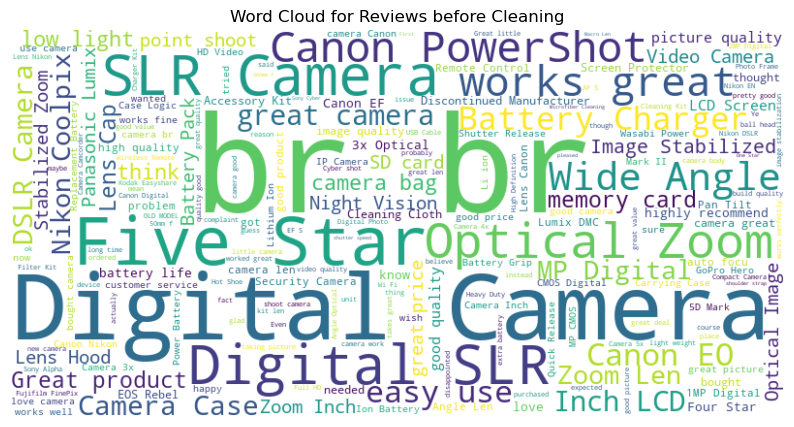

In [24]:
def worl_cloud(attribute, label):
  all_reviews_combined = " ".join(reviews_data[attribute])
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_combined)
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for {label}')
  plt.show()

worl_cloud('combined-without-stopwords', 'Reviews before Cleaning')

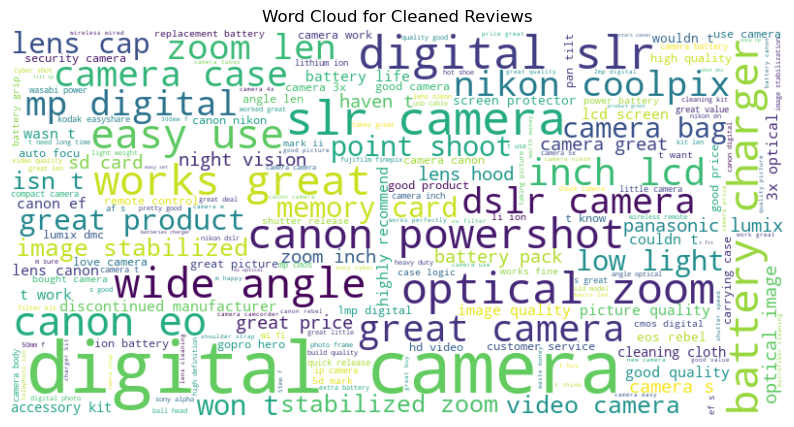

In [25]:
worl_cloud('cleaned_without_stopwords', 'Cleaned Reviews')

[('I', 3839617), ('camera', 1243783), ('The', 927106), ('Camera', 791379), ('Canon', 600342), ('/><br', 584405), ('Digital', 579179), ('It', 518735), ('great', 482848), ('-', 474655), ('good', 460881), ('use', 455441), ('lens', 452848), ('This', 452097), ('Nikon', 401179), ('like', 386334), ('Lens', 338376), ('quality', 305028), ('battery', 304675), ('Great', 303581)]


/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/860129735.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in top_n_words], y=[word[0] for word in top_n_words], palette='pastel')


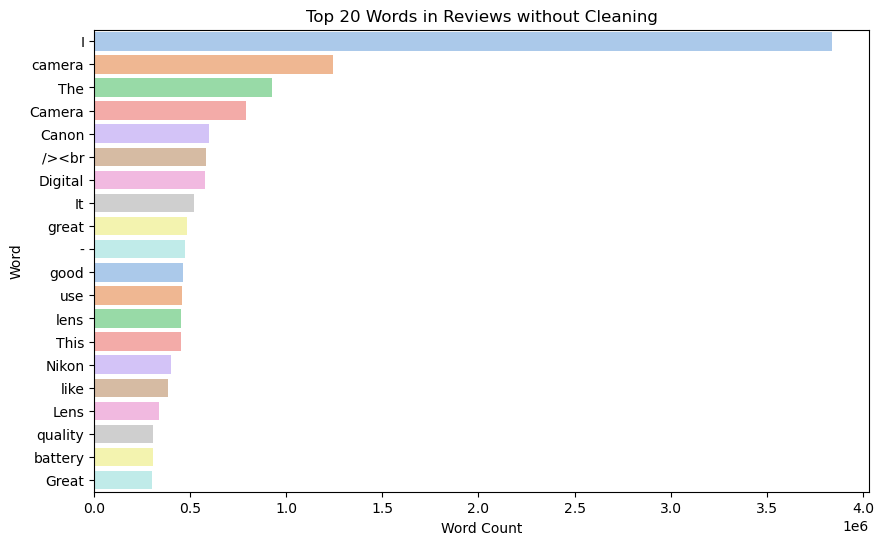

In [ ]:
def barplot_most_freq_words(attribute, num_of_words, label):
    words = ' '.join(reviews_data[attribute]).split()
    word_counts = Counter(words)
    
    # Get top 20 words and their counts
    top_n_words = word_counts.most_common(num_of_words)
    print(top_n_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word[1] for word in top_n_words], y=[word[0] for word in top_n_words], palette='pastel')
    plt.xlabel('Word Count')
    plt.ylabel('Word')
    plt.title(f'Top 20 Words in {label}')
    plt.show()

barplot_most_freq_words('combined-without-stopwords', 20, 'Reviews without Cleaning')

[('camera', 2581954), ('lens', 997432), ('great', 977824), ('t', 880911), ('s', 828625), ('canon', 701971), ('good', 700654), ('digital', 691204), ('battery', 667128), ('use', 595434), ('nikon', 466036), ('2', 458495), ('quality', 441647), ('like', 426952), ('case', 423798), ('3', 419782), ('cameras', 408623), ('1', 397923), ('zoom', 397565), ('video', 396422)]


/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/860129735.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in top_n_words], y=[word[0] for word in top_n_words], palette='pastel')


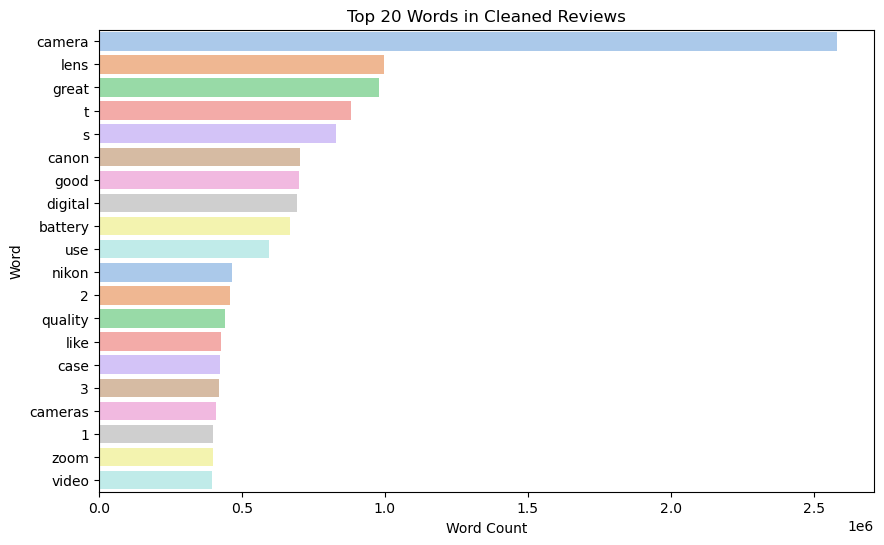

In [32]:
barplot_most_freq_words('cleaned_without_stopwords', 20, 'Cleaned Reviews')

/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/2423617086.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words], palette='pastel')
/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/2423617086.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words], palette='pastel')
/var/folders/xg/bbnwvbx1417dhq4yrqz43j_h0000gn/T/ipykernel_81612/2423617086.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

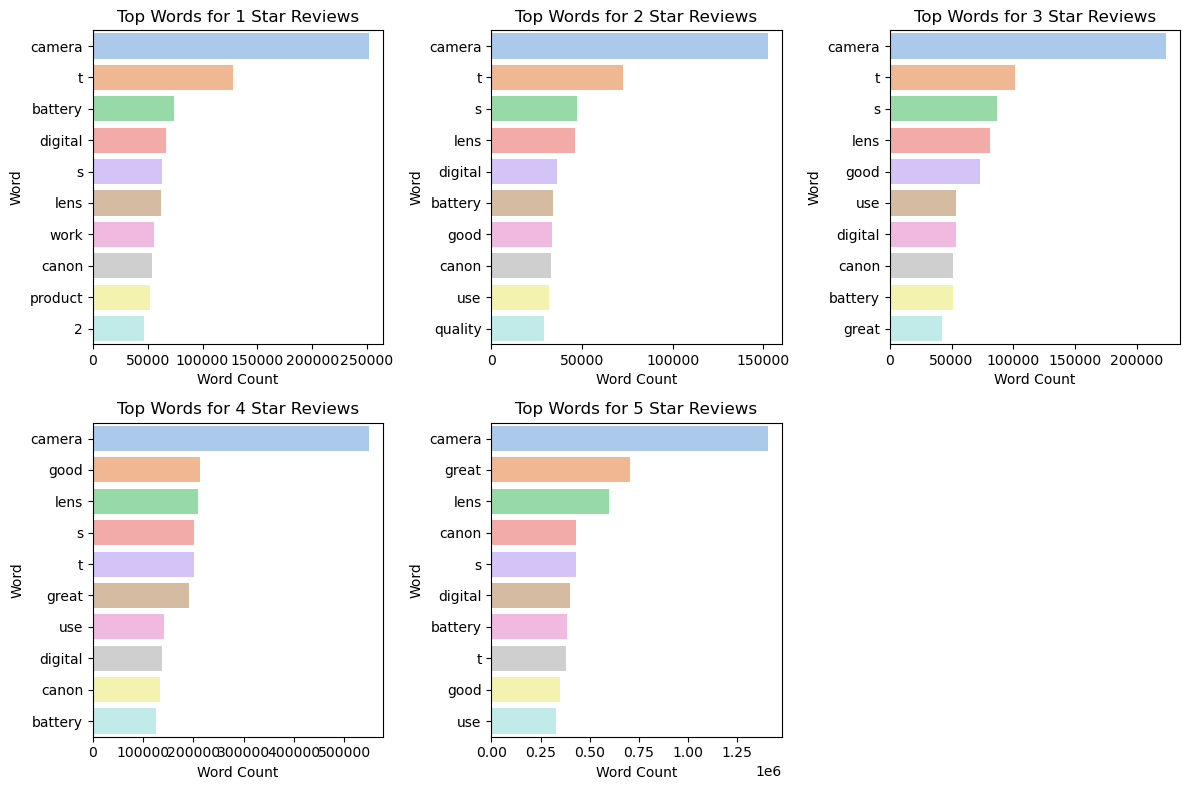

In [36]:
def barpot_for_ratings(attribute1, attribute2, num_of_words):
    top_n_words_per_rating = {}
    for rating in range(1, 6):
        words = ' '.join(reviews_data[reviews_data[attribute2] == rating][attribute1]).split()
        word_counts = Counter(words)
        top_n_words_per_rating[rating] = word_counts.most_common(num_of_words)

    plt.figure(figsize=(12, 8))
    for rating, top_words in top_n_words_per_rating.items():
        plt.subplot(2, 3, rating)
        sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words], palette='pastel')
        plt.xlabel('Word Count')
        plt.ylabel('Word')
        plt.title(f'Top Words for {rating} Star Reviews')
    plt.tight_layout()
    plt.show()

barpot_for_ratings('cleaned_without_stopwords', 'star_rating', 10) 

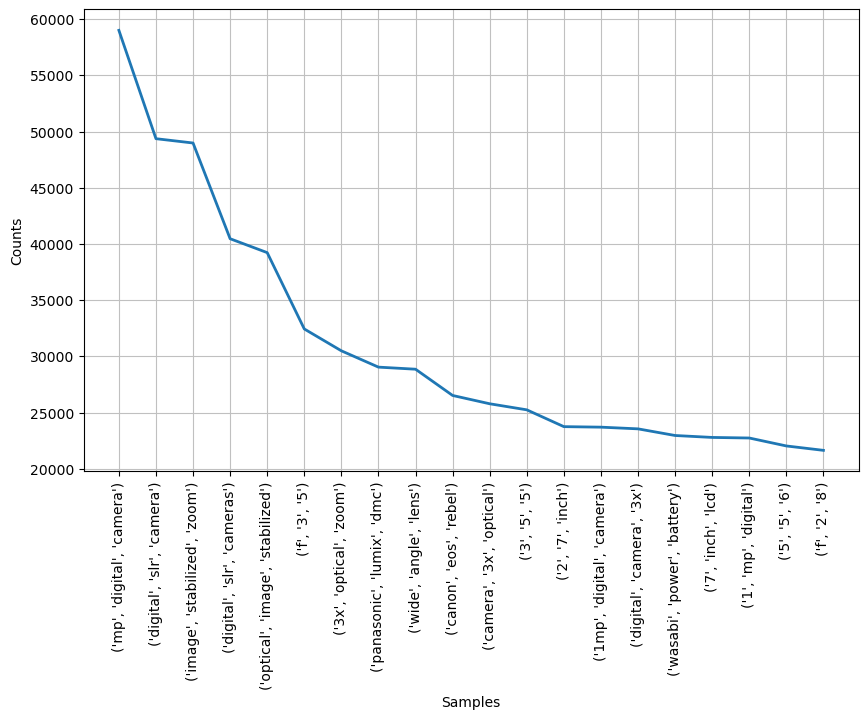

In [34]:
from nltk.util import ngrams
from nltk import FreqDist
def plot_ngram(attribute, n):
    all_words = ' '.join(reviews_data[attribute]).split()
    n_grams = list(ngrams(all_words, n))
    n_gram_freq = FreqDist(n_grams)
    
    plt.figure(figsize=(10, 6))
    n_gram_freq.plot(20, cumulative=False)

    plt.show()

plot_ngram('cleaned_without_stopwords', 3)
